### APAN5420 Anomaly Detection - Assignment 10

### Name: Kanyarat Suwannama

* **Section1**: Data Preparation
* **Section2**: Modeling in H2o
* **Section3**: Feature Engineering 
* **Section4**: GLM model 
* **Section5**: autoML model
* **Section6**: Conclusion

# Section 1: Data preparation

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Use Pandas to do data preparation

In [2]:
data = pd.read_csv("XYZloan_default_selected_vars.csv")

### This is description

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     data, test_size=0.40, random_state=42)

In [4]:
train.shape

(48000, 89)

In [5]:
var = pd.DataFrame(train.dtypes)
var.head(10)

,0
Unnamed: 0.1,int64
Unnamed: 0,int64
id,int64
loan_default,int64
AP001,int64
AP002,int64
AP003,int64
AP004,int64
AP005,object
AP006,object


In [6]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [7]:
var.columns = ['varname','dtype'] 
var.head(10)

,varname,dtype
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64
5,AP002,int64
6,AP003,int64
7,AP004,int64
8,AP005,object
9,AP006,object


In [8]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0.1,int64,Un
1,Unnamed: 0,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [9]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

In [10]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [11]:
train['loan_default'].value_counts(dropna=False)

0    38736
1     9264
Name: loan_default, dtype: int64

# Section 2:  Feature Engineering 

### Bin the train and test dataset

In [12]:
features = ['loan_default','AP001', 'AP003', 'AP008', 'CR009', 'CR015', 'CR019', 'PA022', 'PA023', 'PA029', 'TD001', 'TD005', 'TD006', 'TD009', 'TD010', 'TD014']
df = data[features]

In [13]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values_per = (df.isnull().sum() / df.isnull().count())
pd.concat([missing_values, missing_values_per],axis=1, keys = ['Count_of_Missing','Percentage'])

,Count_of_Missing,Percentage
loan_default,0,0.000000
AP001,0,0.000000
AP003,0,0.000000
AP008,0,0.000000
CR009,0,0.000000
CR015,0,0.000000
CR019,0,0.000000
PA022,381,0.004763
PA023,381,0.004763
PA029,381,0.004763


In [14]:
r = pd.concat([missing_values, missing_values_per],axis=1, keys = ['Count_of_Missing','Percentage']).reset_index()
r

,index,Count_of_Missing,Percentage
0,loan_default,0,0.000000
1,AP001,0,0.000000
2,AP003,0,0.000000
3,AP008,0,0.000000
4,CR009,0,0.000000
5,CR015,0,0.000000
6,CR019,0,0.000000
7,PA022,381,0.004763
8,PA023,381,0.004763
9,PA029,381,0.004763


In [15]:
def null_cell(df):
    dfx = df.copy()
    missing_values = dfx.isnull().sum()
    missing_values_per = dfx.isnull().sum() / dfx.isnull().count()
    null_values = pd.concat([missing_values, missing_values_per],axis=1, keys = ['the_null','the_null_perc'])
    null_values = null_values.sort_values('the_null',ascending=False)
    return null_values[null_values['the_null']>0]

fill_list = (null_cell(df)).index
fill_list

Index(['PA022', 'PA023', 'PA029'], dtype='object')

In [16]:
r.loc[r['index']=='type','Percentage']

Series([], Name: Percentage, dtype: float64)

In [17]:
df_mean = df # Do you know this is different from "df_mean = df.copy()?"" This just point to the same data frame. It does not create a copy.
df_mean = df.copy() # Here create a physical copy of df.

In [18]:
for col in fill_list:
    df_mean.loc[:,col].fillna(df_mean.loc[:,col].mean(),inplace=True)

In [19]:
predictors = ['AP001','AP003','AP008','CR009', 'CR015', 'CR019','PA022', 'PA023', 'PA029',
             'TD001', 'TD005', 'TD006', 'TD009', 'TD010', 'TD014']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_mean[predictors],
                                                    df_mean['loan_default'], 
                                                    train_size=0.1, random_state=1234)

In [21]:
train = pd.concat([X_train, Y_train], axis=1)
len(train)

8000

In [22]:
test = pd.concat([X_test, Y_test], axis=1)
len(test)

72000

### Binning the train and test dataset

In [23]:
def binning(var, train, test):
    # Define the extreme values 
    extreme_val = [-99,-98,-1]
    
    # Fit the extreme values into single category
    train.loc[train[var]==-99, var+'_bin']=-99
    train.loc[train[var]==-1, var+'_bin']=-1
    train.loc[train[var]==-98, var+'_bin']=-98
    
    # Separate the dataset into two parts based on whether the values of a variable are in a list of extreme values
    special_train = train.loc[train[var].isin(extreme_val)]
    normal_train = train.loc[-train[var].isin(extreme_val)]
    
    # Transfer the continuous variable to categorical binned variables 
    s, b = pd.qcut(normal_train[var], 10, duplicates='drop', retbins=True)

    normal_train[var+'_bin'] = pd.cut(normal_train[var], bins=b, duplicates='drop').astype(str)
    
    # Recombine the data
    train=pd.concat([special_train, normal_train], axis=0)
    
    # Put the extreme value in specific categories
    test.loc[test[var]==-99, var+'_bin']=-99
    test.loc[test[var]==-1, var+'_bin']=-1
    test.loc[test[var]==-98, var+'_bin']=-98
    
    # Separate the dataset into two parts based on whether the values of a variable are in a list of extreme values
    special_test = test.loc[test[var].isin(extreme_val)]
    normal_test = test.loc[-test[var].isin(extreme_val)]
    
    # Use the binning range in train dataset to cut the test data
    # Return the list of the bins in training data set and applied it into test set
    normal_test[var+'_bin'] = pd.cut(normal_test[var], bins=b, duplicates='drop').astype(str)
    
    # Recombine the data
    test=pd.concat([special_test, normal_test], axis=0)
    
    # Categorize NA in a new category -- 'NoData'
    train[var+'_bin'] = train[var+'_bin'].fillna('NoData')
    test[var+'_bin'] = test[var+'_bin'].fillna('NoData')

    return train, test

# Apply the binning function to each predictor variable
for i in predictors:
    train, test = binning(i, train, test)

# Create a list of the binned predictor variable names
features_bin = [f + '_bin' for f in predictors]
features_bin

['AP001_bin',
 'AP003_bin',
 'AP008_bin',
 'CR009_bin',
 'CR015_bin',
 'CR019_bin',
 'PA022_bin',
 'PA023_bin',
 'PA029_bin',
 'TD001_bin',
 'TD005_bin',
 'TD006_bin',
 'TD009_bin',
 'TD010_bin',
 'TD014_bin']

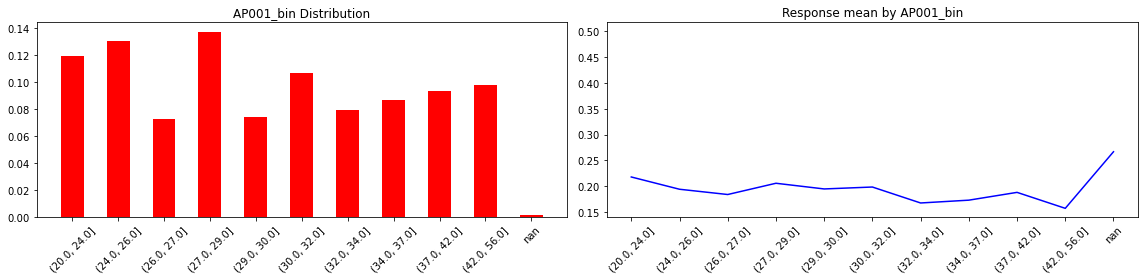

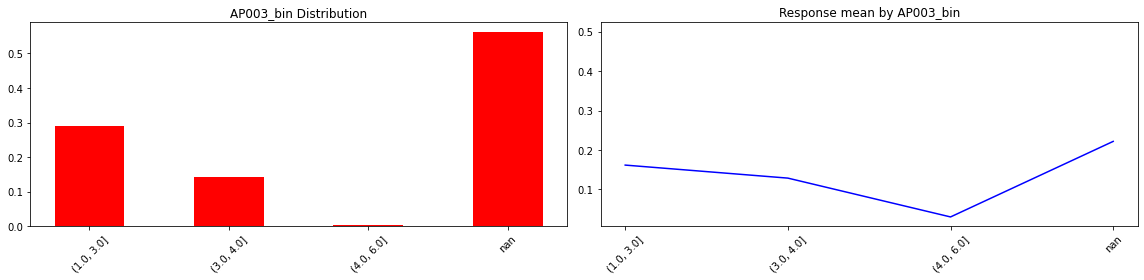

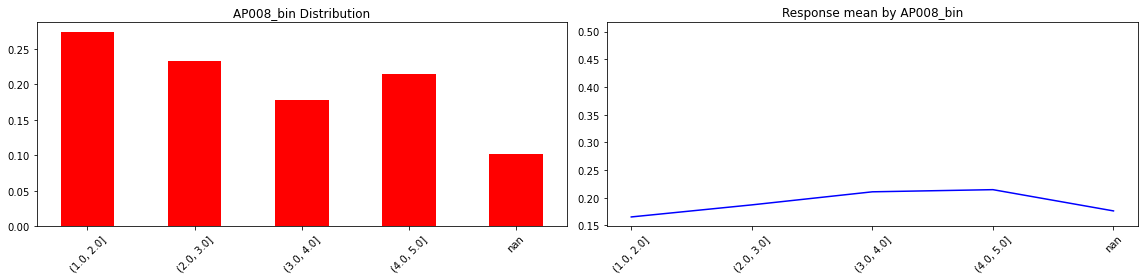

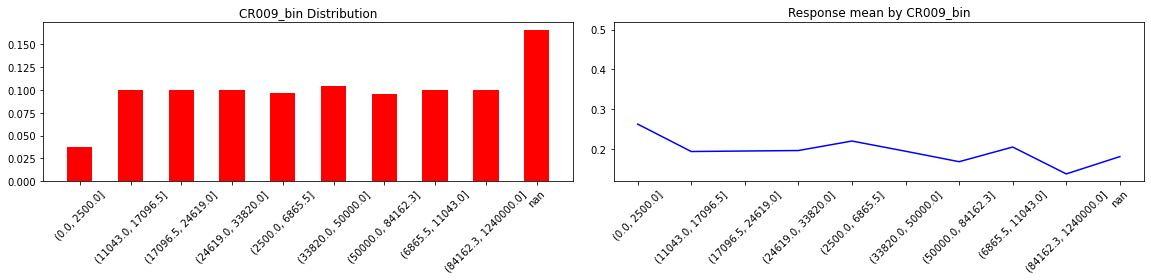

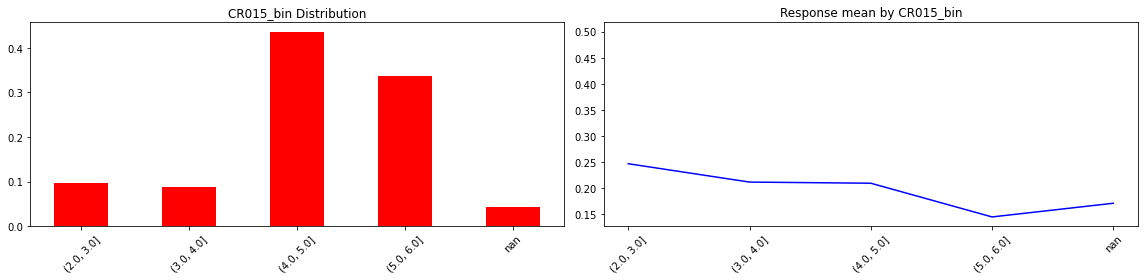

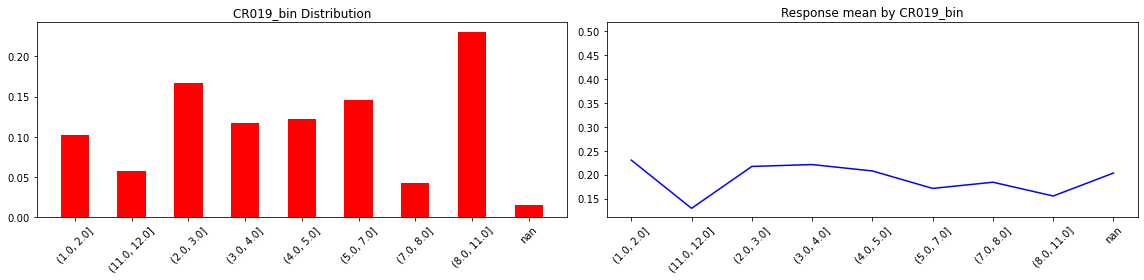

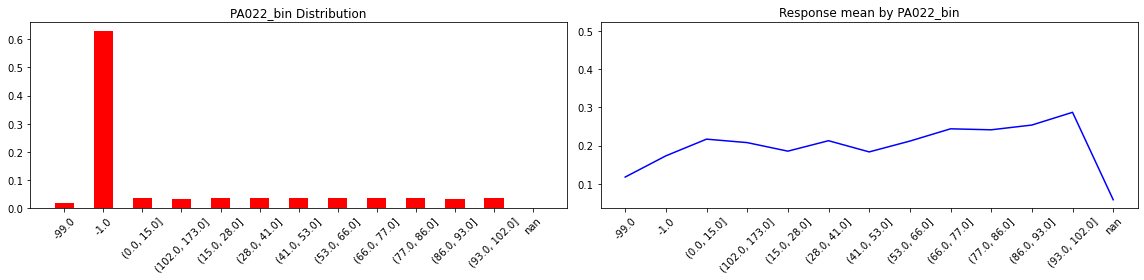

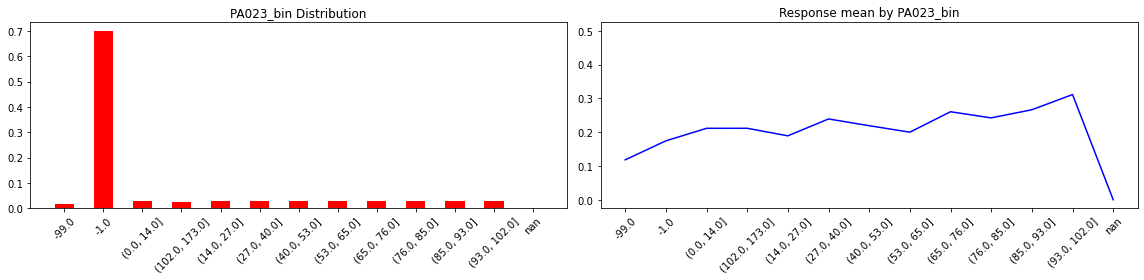

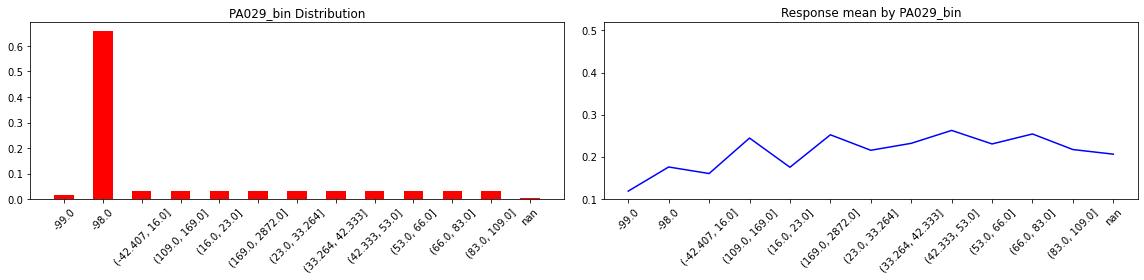

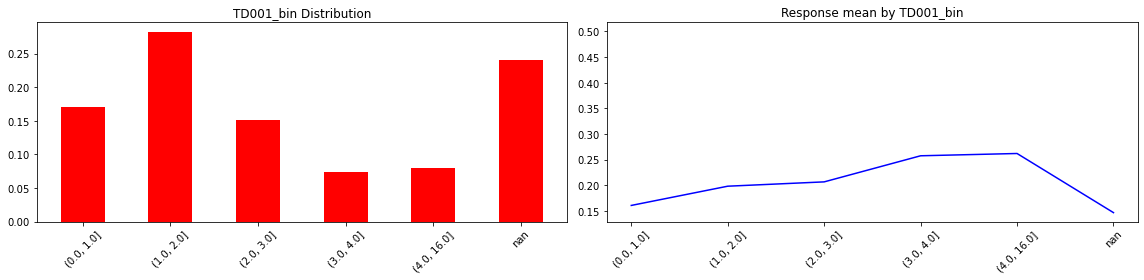

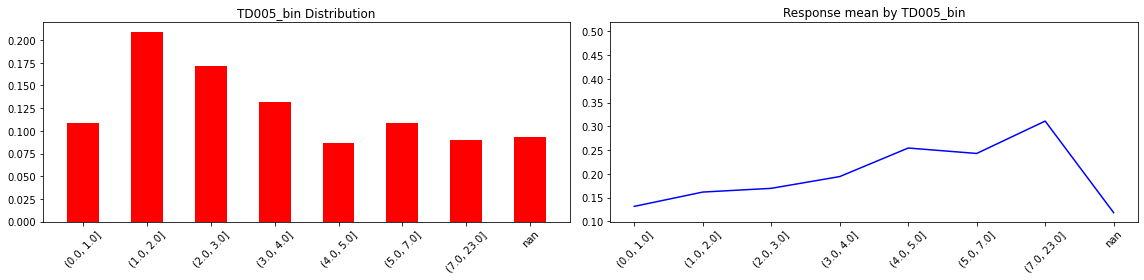

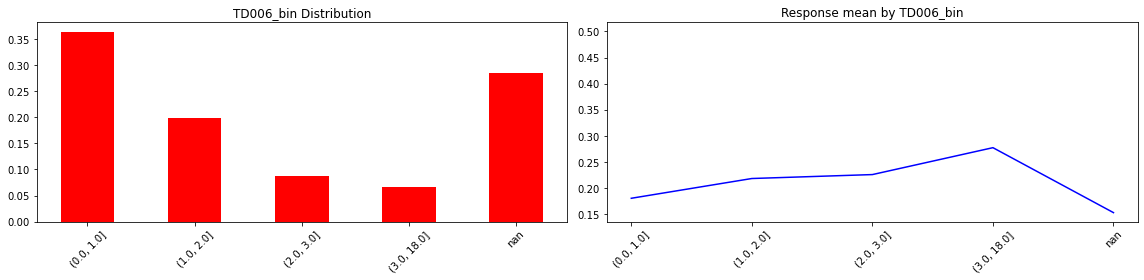

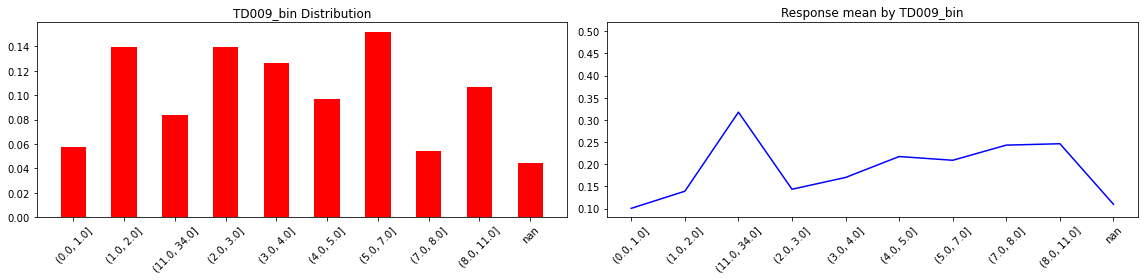

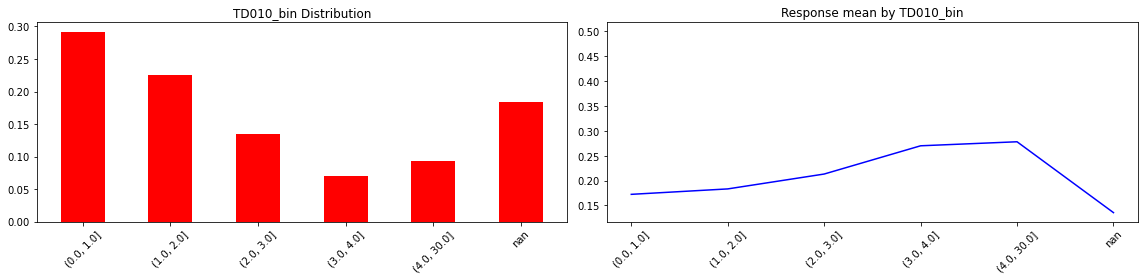

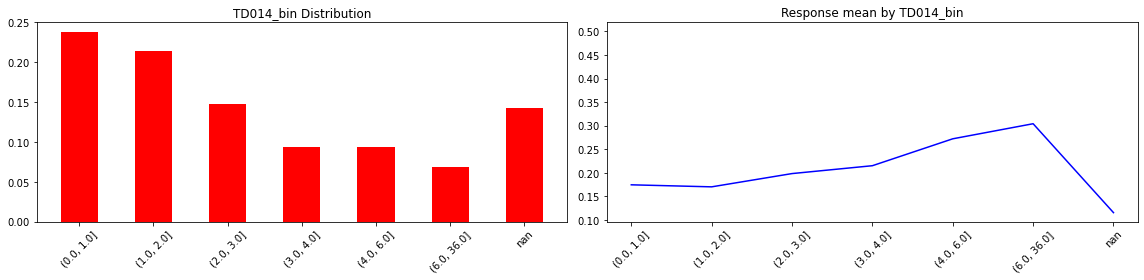

In [24]:
# Show the distribution of the train dataset
def plot_X_and_Y(var):
    z = train.groupby(var)['loan_default'].agg(['count', 'mean']).reset_index() 
    z['count_pcnt'] = z['count']/z['count'].sum()
    x = z[var]
    y_mean = z['mean']
    count_pcnt = z['count_pcnt']
    ind = np.arange(0, len(x))
    width = .5

    fig, axs = plt.subplots(ncols=2, figsize=(16,4))
    axs[0].bar(ind, count_pcnt, width, color='r')
    axs[0].set_title(var + ' Distribution')
    axs[0].set_xticks(ind)
    axs[0].set_xticklabels(x.tolist(), rotation=45)
    
    axs[1].plot(ind, y_mean, width, color='b')
    axs[1].set_title('Response mean by ' + var)
    axs[1].set_xticks(ind)
    axs[1].set_xticklabels(x.tolist(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
for i in features_bin:
    plot_X_and_Y(i) 

### WOE transformation

In [25]:
# Create WOE function
def WOE(var, train):
    train[var] = train[var].fillna('NoData')
    k = train[[var,'loan_default']].groupby(var)['loan_default'].agg(['count','sum']).reset_index()
    k.columns = [var,'Count','Good']
    k['Bad'] = k['Count'] - k['Good']
    k['Good %'] = (k['Good'] / k['Good'].sum()*100).round(2)
    k['Bad %'] = (k['Bad'] / k['Bad'].sum()*100).round(2)
    k[var+'_WOE'] = np.log(k['Good %'] / k['Bad %']).round(2)
    k = k.sort_values(by=var+'_WOE')
    
    return(k)

In [26]:
for f in features_bin:
    try:
        k = WOE(f, train)
        train[f+'_WOE'] = train[f].map(k.set_index(f)[f+'_WOE'])
        train[f+'_WOE'] = train[f+'_WOE'].fillna(k[f+'_WOE'].iloc[-1])
        test[f+'_WOE'] = test[f].map(k.set_index(f)[f+'_WOE'])
        test[f+'_WOE'] = test[f+'_WOE'].fillna(k[f+'_WOE'].iloc[-1])
        #Merge WOE variable from training dataset to test dataset
        test[f+'_WOE'] = test[f+'_WOE'].fillna(train[f+'_WOE'].iloc[-1])
    except:
        pass

# Section 3: H2O

H2O has proven to be one of the favorite tools of many data scientists. It streamlines modeling development and production and can produce models that can be run in other languages such as Java.

In [27]:
#pip install h2o

In [28]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_361"; Java(TM) SE Runtime Environment (build 1.8.0_361-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.361-b09, mixed mode)
  Starting server from /Users/kanyaratsuwannama/opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/4q/w1lktl152hx0j0gq933rclnh0000gn/T/tmpbi1we764
  JVM stdout: /var/folders/4q/w1lktl152hx0j0gq933rclnh0000gn/T/tmpbi1we764/h2o_kanyaratsuwannama_started_from_python.out
  JVM stderr: /var/folders/4q/w1lktl152hx0j0gq933rclnh0000gn/T/tmpbi1we764/h2o_kanyaratsuwannama_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_kanyaratsuwannama_ltyzap
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [29]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [30]:
predictors = ['AP001_bin_WOE', 'AP003_bin_WOE', 'AP008_bin_WOE', 'CR009_bin_WOE', 'CR015_bin_WOE', 'CR019_bin_WOE', 'PA022_bin_WOE', 'PA023_bin_WOE', 'PA029_bin_WOE', 'TD001_bin_WOE', 'TD005_bin_WOE', 'TD006_bin_WOE', 'TD009_bin_WOE', 'TD010_bin_WOE', 'TD014_bin_WOE']
target = 'loan_default'

In [31]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [32]:
#h2o.cluster().shutdown()

# Section 4: GLM models

GLM stands for Generalized Linear Model. It is a statistical framework used to model the relationship between a response variable and one or more predictor variables. The GLM generalizes linear regression by allowing the response variable to have a non-normal distribution and by using a link function to model the relationship between the response variable and the predictors.

### Model 1 - H2O Generalized Linear Model without Regularization

In [33]:
# GLM without regulatization
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
GLM_WO = H2OGeneralizedLinearEstimator(family= "binomial",
                                          lambda_ = 0,
                                          compute_p_values = True)
GLM_WO.train(predictors, target, training_frame= train_hex)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1680652446636_1


GLM Model: summary
    family    link    regularization    number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ----------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    binomial  logit   None              15                            15                             4                       Key_Frame__upload_bea848df80229bd42534d3f32f0d4162.hex

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.15478262857374564
RMSE: 0.3934242348581816
LogLoss: 0.47850670414350627
AUC: 0.6854584669523511
AUCPR: 0.33427143719562297
Gini: 0.37091693390470226
Null degrees of freedom: 799
Residual degrees of freedom: 784
Null deviance: 819.6732764869606
Residual deviance: 765.61072662961
AIC: 797.61072662961

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18446481079029073
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      347  286  0.4518   (286.0/633.0)
1      43   124  0.2575   (43.0/167.0)
Total  390  410  0.4113   (329.0/800.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.184465     0.429809  226
max f2                       0.125994     0.609756  305
max f0point5                 0.289809     0.382082  104
max accuracy                 0.494808     0.79375   10
max precision                0.494808     0.583333  10
max recall                   0.0627814    1         385
max specificity              0.67764      0.99842   0
max absolute_mcc             0.184465     0.236362  226
max min_per_class_accuracy   0.206119     0.627172  196
max mean_per_class_accuracy  0.184465     0.645349  226
max tns                      0.67764      632       0
max fns                      0.67764      167       0
max fps                      0.00653496   633       399
max tps                      0.0627814    167       385
max tnr                      0.67764      0.99842   0
max fnr                      0.67764      1         0
max fpr                      0.00653496   1         399
max tpr                      0.0627814    1         385

Gains/Lift Table: Avg response rate: 20.88 %, avg score: 35.07 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.590266           0         0                  0                0.833186  0                           0.833186            0               0                          -100      -100               -0.0126382
2        0.02                        0.529771           2.39521   1.1976             0.5              0.560806  0.25                        0.696996            0.0239521       0.0239521                  139.521   19.7605            0.00499475
3        0.03                        0.516547           0         0.798403           0                0.526003  0.166667                    0.639998            0               0.0239521                  -100      -20.1597           -0.00764348
4        0.04                        0.494496           0.598802  0.748503           0.125            0.503033  0.15625                     0.605757            0.00598802      0.0299401                  -40.1198  -25.1497           -0.01271

In [34]:
GLM_WO.predict(test_hex)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1,StdErr
1,0.761188,0.238812,0.376274
0,0.826639,0.173361,0.353476
1,0.761837,0.238163,0.354311
1,0.651768,0.348232,0.321249
0,0.857999,0.142001,0.492187
1,0.575905,0.424095,0.355046
1,0.647276,0.352724,0.310864
0,0.914301,0.0856986,0.490814
1,0.743361,0.256639,0.447617
1,0.608304,0.391696,0.303851


In [35]:
predictions = GLM_WO.predict(test_hex)['p1']
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,loan_default,p1
0,0,0.238812
1,0,0.173361
2,0,0.238163
3,0,0.348232
4,0,0.142001


In [36]:
y_pred = GLM_WO.predict(test_hex).as_data_frame()
y_pred.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,predict,p0,p1,StdErr
0,1,0.761188,0.238812,0.376274
1,0,0.826639,0.173361,0.353476
2,1,0.761837,0.238163,0.354311
3,1,0.651768,0.348232,0.321249
4,0,0.857999,0.142001,0.492187


In [37]:
from sklearn.metrics import roc_auc_score
def actual_predict(model,test_hex,target):
    y_pred = model.predict(test_hex).as_data_frame()
    y_actual = test_hex[target].as_data_frame()
    df_actual_predict = pd.concat([y_actual,y_pred],axis=1)
    df_actual_predict.columns = ['actual','pred']
    return(df_actual_predict)

In [38]:
y_actual = test_hex[target].as_data_frame()
GLM_WO_actual_predict = pd.concat([y_actual,y_pred['predict']],axis=1)
GLM_WO_actual_predict.columns = ['actual','pred']
GLM_WO_actual_predict.head()

,actual,pred
0,0,1
1,0,0
2,0,1
3,0,1
4,0,0


In [39]:
GLM_WO_roc_auc_value = roc_auc_score(GLM_WO_actual_predict['actual'], GLM_WO_actual_predict['pred'])
GLM_WO_roc_auc_value

0.5919167241942926

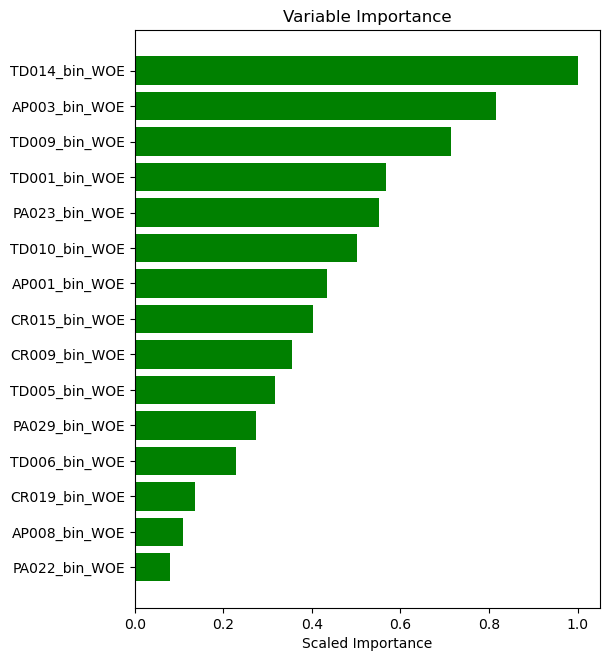

In [40]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

VarImp(GLM_WO)

In [41]:
# function to plot the Cumulative lift
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(GLM_WO)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,720,187,533,720,187,533,0.13,0.09,142.7,1.31,4.0,25.97
1,720,182,538,1440,369,1071,0.26,0.19,285.4,1.29,7.0,25.62
2,720,182,538,2160,551,1609,0.39,0.28,428.1,1.29,11.0,25.51
3,720,181,539,2880,732,2148,0.51,0.37,570.8,1.28,14.0,25.42
4,720,187,533,3600,919,2681,0.64,0.46,713.5,1.29,18.0,25.53
5,720,107,613,4320,1026,3294,0.72,0.57,856.2,1.20,15.0,23.75
6,720,104,616,5040,1130,3910,0.79,0.68,998.9,1.13,11.0,22.42
7,720,103,617,5760,1233,4527,0.86,0.78,1141.6,1.08,8.0,21.41
8,720,103,617,6480,1336,5144,0.94,0.89,1284.3,1.04,5.0,20.62


In [42]:
# function to plot the ROC curve
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df)['p1'].as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



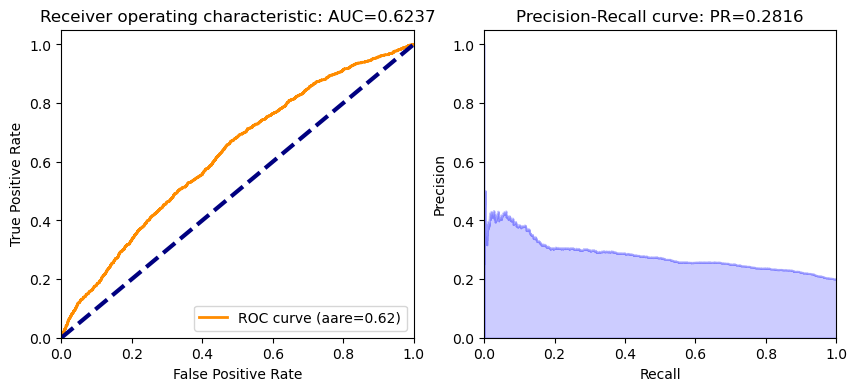

In [43]:
ROC_AUC(GLM_WO,test_hex,'loan_default')

### Model 2 - H2O Generalized Linear Model with Regularization

In [44]:
GLM_WITH = H2OGeneralizedLinearEstimator(family= "binomial",
                                          lambda_search = True)
GLM_WITH.train(predictors, target, training_frame= train_hex)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1680652446636_3


GLM Model: summary
    family    link    regularization                                 lambda_search                                                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------------------------  ----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 0.001636 )  nlambda = 100, lambda.max = 0.1182, lambda.min = 0.001636, lambda.1se = -1.0  15                            14                             61                      Key_Frame__upload_bea848df80229bd42534d3f32f0d4162.hex

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.15475855775885397
RMSE: 0.39339364224508505
LogLoss: 0.47863836603821547
AUC: 0.6845314111114265
AUCPR: 0.33350535381372626
Gini: 0.3690628222228529
Null degrees of freedom: 799
Residual degrees of freedom: 785
Null deviance: 819.6732764869606
Residual deviance: 765.8213856611447
AIC: 795.8213856611447

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18806752395079093
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      349  284  0.4487   (284.0/633.0)
1      44   123  0.2635   (44.0/167.0)
Total  393  407  0.41     (328.0/800.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.188068     0.428571  232
max f2                       0.126275     0.606532  315
max f0point5                 0.254454     0.381643  148
max accuracy                 0.478459     0.79375   11
max precision                0.478459     0.583333  11
max recall                   0.0676355    1         386
max specificity              0.657952     0.99842   0
max absolute_mcc             0.17205      0.234896  251
max min_per_class_accuracy   0.211497     0.628743  202
max mean_per_class_accuracy  0.188068     0.643935  232
max tns                      0.657952     632       0
max fns                      0.657952     167       0
max fps                      0.00741746   633       399
max tps                      0.0676355    167       386
max tnr                      0.657952     0.99842   0
max fnr                      0.657952     1         0
max fpr                      0.00741746   1         399
max tpr                      0.0676355    1         386

Gains/Lift Table: Avg response rate: 20.88 %, avg score: 20.88 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.524252           1.79641   1.79641            0.375            0.581291   0.375                       0.581291            0.0179641       0.0179641                  79.6407   79.6407            0.0100652
2        0.02                        0.465795           2.99401   2.39521            0.625            0.491153   0.5                         0.536222            0.0299401       0.0479042                  199.401   139.521            0.035266
3        0.03                        0.446506           1.79641   2.19561            0.375            0.456613   0.458333                    0.509686         

In [45]:
y_pred = GLM_WITH.predict(test_hex).as_data_frame()
y_actual = test_hex[target].as_data_frame()
y_pred.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,predict,p0,p1
0,1,0.760501,0.239499
1,0,0.823180,0.176820
2,1,0.756817,0.243183
3,1,0.674437,0.325563
4,0,0.848684,0.151316


In [46]:
GLM_WITH_actual_predict = pd.concat([y_actual,y_pred['predict']],axis=1)
GLM_WITH_actual_predict.columns = ['actual','pred']
GLM_WITH_actual_predict.head()

,actual,pred
0,0,1
1,0,0
2,0,1
3,0,1
4,0,0


In [47]:
GLM_WITH_roc_auc_value = roc_auc_score(GLM_WITH_actual_predict['actual'], GLM_WITH_actual_predict['pred'])
GLM_WITH_roc_auc_value

0.5904678413186777

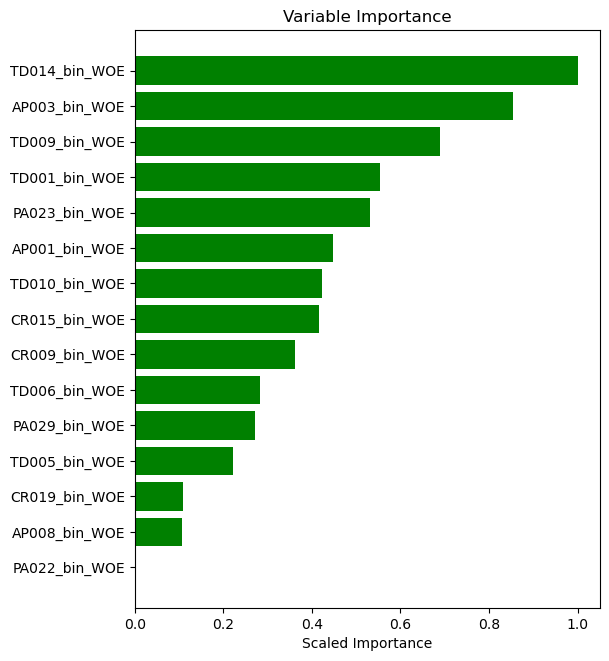

In [48]:
VarImp(GLM_WITH)

In [49]:
createGains(GLM_WITH)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,720,188,532,720,188,532,0.13,0.09,142.7,1.32,4.0,26.11
1,720,187,533,1440,375,1065,0.26,0.18,285.4,1.31,8.0,26.04
2,720,179,541,2160,554,1606,0.39,0.28,428.1,1.29,11.0,25.65
3,720,172,548,2880,726,2154,0.51,0.37,570.8,1.27,14.0,25.21
4,720,194,526,3600,920,2680,0.64,0.46,713.5,1.29,18.0,25.56
5,720,118,602,4320,1038,3282,0.73,0.57,856.2,1.21,16.0,24.03
6,720,114,606,5040,1152,3888,0.81,0.67,998.9,1.15,14.0,22.86
7,720,95,625,5760,1247,4513,0.87,0.78,1141.6,1.09,9.0,21.65
8,720,96,624,6480,1343,5137,0.94,0.89,1284.3,1.05,5.0,20.73


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



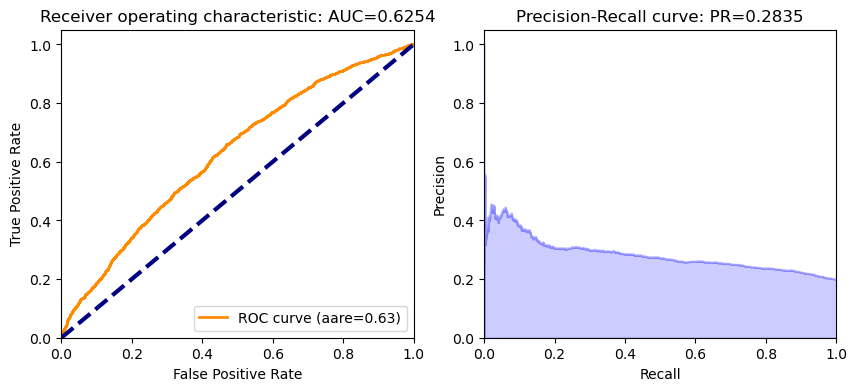

In [50]:
ROC_AUC(GLM_WITH,test_hex,'loan_default')

### Model 3

H2OGridSearch is a function in H2O that helps find the best hyperparameters for a machine learning algorithm by exploring a pre-defined hyperparameter grid and training and evaluating a model for each combination of hyperparameters. It can be used with different algorithms in H2O, and it returns the best model and its hyperparameters.

In [51]:
from h2o.grid.grid_search import H2OGridSearch
glm_params = {"alpha": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

In [52]:
glm_grid = H2OGridSearch(model=H2OGeneralizedLinearEstimator(
                                                    family = "binomial", 
                                                    lambda_search=True),
                     hyper_params=glm_params)

In [53]:
glm_grid.train(predictors,target,training_frame=train_hex)

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,alpha,model_ids,logloss
,0.9,Grid_GLM_Key_Frame__upload_bea848df80229bd42534d3f32f0d4162.hex_model_python_1680652446636_5_model_5,0.4786278
,0.8,Grid_GLM_Key_Frame__upload_bea848df80229bd42534d3f32f0d4162.hex_model_python_1680652446636_5_model_4,0.4786325
,0.5,Grid_GLM_Key_Frame__upload_bea848df80229bd42534d3f32f0d4162.hex_model_python_1680652446636_5_model_1,0.4786384
,0.7,Grid_GLM_Key_Frame__upload_bea848df80229bd42534d3f32f0d4162.hex_model_python_1680652446636_5_model_3,0.4786387
,1.0,Grid_GLM_Key_Frame__upload_bea848df80229bd42534d3f32f0d4162.hex_model_python_1680652446636_5_model_6,0.4786431
,0.6,Grid_GLM_Key_Frame__upload_bea848df80229bd42534d3f32f0d4162.hex_model_python_1680652446636_5_model_2,0.4786473


In [54]:
GLM_GRID = H2OGeneralizedLinearEstimator(family="binomial",
                                          alpha=0.9,
                                          lambda_search=True,
                                          generate_variable_inflation_factors=True,
                                          fold_assignment="modulo",
                                          nfolds=20,
                                          standardize=True,
                                          keep_cross_validation_models=True)
GLM_GRID.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1680652446636_12


GLM Model: summary
    family    link    regularization                                 lambda_search                                                                     number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------------------------  --------------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    binomial  logit   Elastic Net (alpha = 0.9, lambda = 0.006414 )  nlambda = 100, lambda.max = 0.06565, lambda.min = 0.006414, lambda.1se = 0.06565  15                            11                             39                      Key_Frame__upload_bea848df80229bd42534d3f32f0d4162.hex

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.15516367314624843
RMSE: 0.39390820395905496
LogLoss: 0.48087474334753116
AUC: 0.6786805535847736
AUCPR: 0.3375863507937197
Gini: 0.3573611071695473
Null degrees of freedom: 799
Residual degrees of freedom: 788
Null deviance: 819.6732764869606
Residual deviance: 769.3995893560499
AIC: 793.3995893560499

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1904010762911958
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      343  290  0.4581   (290.0/633.0)
1      43   124  0.2575   (43.0/167.0)
Total  386  414  0.4163   (333.0/800.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.190401     0.42685   230
max f2                       0.131953     0.602273  321
max f0point5                 0.26117      0.368364  128
max accuracy                 0.578051     0.7925    0
max precision                0.578051     1         0
max recall                   0.0854885    1         380
max specificity              0.578051     1         0
max absolute_mcc             0.190401     0.231294  230
max min_per_class_accuracy   0.210278     0.617694  199
max mean_per_class_accuracy  0.190401     0.64219   230
max tns                      0.578051     633       0
max fns                      0.578051     166       0
max fps                      0.0130944    633       399
max tps                      0.0854885    167       380
max tnr                      0.578051     1         0
max fnr                      0.578051     0.994012  0
max fpr                      0.0130944    1         399
max tpr                      0.0854885    1         380

Gains/Lift Table: Avg response rate: 20.88 %, avg score: 20.88 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.461274           2.39521   2.39521            0.5              0.512884   0.5                         0.512884            0.0239521       0.0239521                  139.521   139.521            0.017633
2        0.02                        0.438452           2.39521   2.39521            0.5              0.448249   0.5                         0.480566            0.0239521       0.0479042                  139.521   139.521            0.035266
3        0.03                        0.417487           2.39521   2.39521            0.5              0.431388   0.5                         0.464174 

In [55]:
y_pred = GLM_GRID.predict(test_hex).as_data_frame()
y_actual = test_hex[target].as_data_frame()
y_pred.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,predict,p0,p1
0,1,0.743172,0.256828
1,0,0.818297,0.181703
2,1,0.730599,0.269401
3,1,0.745794,0.254206
4,0,0.816243,0.183757


In [56]:
GLM_GRID_actual_predict = pd.concat([y_actual,y_pred['predict']],axis=1)
GLM_GRID_actual_predict.columns = ['actual','pred']
GLM_GRID_actual_predict.head()

,actual,pred
0,0,1
1,0,0
2,0,1
3,0,1
4,0,0


In [57]:
GLM_GRID_roc_auc_value = roc_auc_score(GLM_GRID_actual_predict['actual'], GLM_GRID_actual_predict['pred'])
GLM_GRID_roc_auc_value

0.5907947382342298

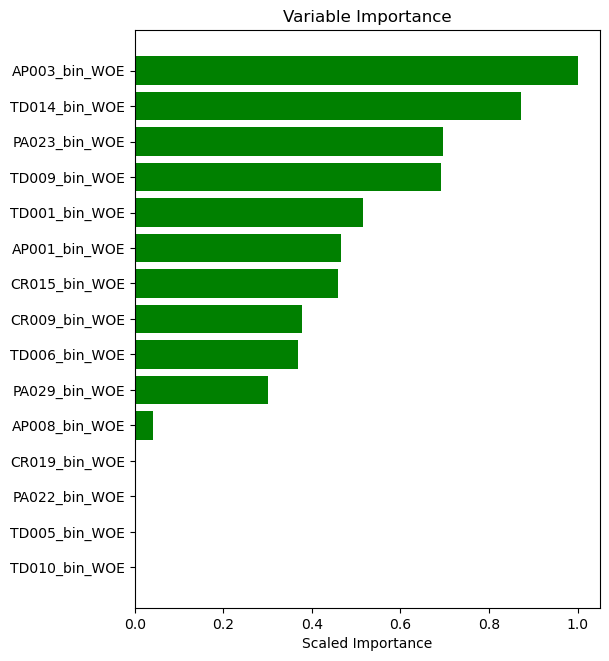

In [58]:
VarImp(GLM_GRID)

In [59]:
createGains(GLM_GRID)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,720,194,526,720,194,526,0.14,0.09,142.7,1.36,5.0,26.94
1,720,182,538,1440,376,1064,0.26,0.18,285.4,1.32,8.0,26.11
2,720,179,541,2160,555,1605,0.39,0.28,428.1,1.30,11.0,25.69
3,720,178,542,2880,733,2147,0.51,0.37,570.8,1.28,14.0,25.45
4,720,182,538,3600,915,2685,0.64,0.47,713.5,1.28,17.0,25.42
5,720,127,593,4320,1042,3278,0.73,0.57,856.2,1.22,16.0,24.12
6,720,110,610,5040,1152,3888,0.81,0.67,998.9,1.15,14.0,22.86
7,720,97,623,5760,1249,4511,0.88,0.78,1141.6,1.09,10.0,21.68
8,720,88,632,6480,1337,5143,0.94,0.89,1284.3,1.04,5.0,20.63


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



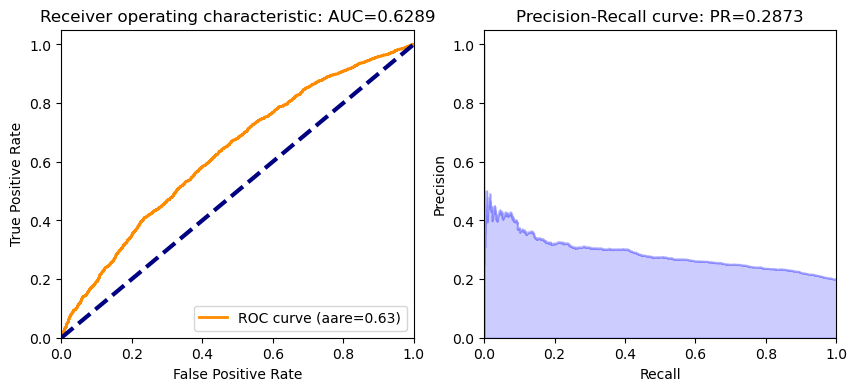

In [60]:
ROC_AUC(GLM_GRID,test_hex,'loan_default')

# Section 5: AutoML models

AutoML refers to automated techniques and tools that simplify the process of building and deploying machine learning models. It automates several steps such as data pre-processing, feature engineering, model selection, hyperparameter tuning, and model deployment. AutoML makes machine learning accessible to a wider range of users, improves the accuracy and robustness of models, and is particularly useful for analyzing large volumes of data and complex modeling tasks.

### Model 1

In [61]:
predictors = ['AP001_bin_WOE', 'AP003_bin_WOE', 'AP008_bin_WOE', 'CR009_bin_WOE', 'CR015_bin_WOE', 'CR019_bin_WOE', 'PA022_bin_WOE', 'PA023_bin_WOE', 'PA029_bin_WOE', 'TD001_bin_WOE', 'TD005_bin_WOE', 'TD006_bin_WOE', 'TD009_bin_WOE', 'TD010_bin_WOE', 'TD014_bin_WOE']
target = 'loan_default'

train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [62]:
from h2o.automl import H2OAutoML
aml_v1 = H2OAutoML(max_runtime_secs = 120, 
                   max_models=20)
aml_v1.train(predictors,target,training_frame=train_hex)

AutoML progress: |
19:54:19.967: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.


19:54:20.402: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
19:54:20.476: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

███
19:54:22.683: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
19:54:22.957: _response param, We have detecte

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20230404_195419


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    25                 25                          3003                   2            4            3.44          4             6             4.92

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.14959929187711915
RMSE: 0.38678067671112937
MAE: 0.30913014941848815
RMSLE: 0.27051485632455347
Mean Residual Deviance: 0.14959929187711915

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.15887307136809706
RMSE: 0.3985888500298234
MAE: 0.31863437260219074
RMSLE: 0.27966309804340234
Mean Residual Deviance: 0.15887307136809706

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     0.317355  0.0147463  0.323633      0.338267      0.304014      0.318151      0.302711
mean_residual_deviance  0.159736  0.0173425  0.161992      0.176852      0.141752      0.176081      0.142004
mse                     0.159736  0.0173425  0.161992      0.176852      0.141752      0.176081      0.142004
r2                      0.030193  0.022587   0.0319796     0.0234244     0.0181683     0.00952021    0.0678723
residual_deviance       0.159736  0.0173425  0.161992      0.176852      0.141752      0.176081      0.142004
rmse                    0.399195  0.0217864  0.402483      0.420537      0.3765        0.41962       0.376834
rmsle                   0.280373  0.0115195  0.282851      0.292662      0.270168      0.289475      0.266711

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2023-04-04 19:54:22  2.113 sec   0                  0.406415         0.330347        0.165173
    2023-04-04 19:54:22  2.134 sec   5                  0.399864         0.32484         0.159891
    2023-04-04 19:54:22  2.152 sec   10                 0.395619         0.320501        0.156514
    2023-04-04 19:54:22  2.165 sec   15                 0.391562         0.315527        0.15332
    2023-04-04 19:54:22  2.178 sec   20                 0.388797         0.31081         0.151163
    2023-04-04 19:54:22  2.196 sec   25                 0.386781         0.30913         0.149599

Variable Importances: 
variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  -------------------  ------------
CR009_bin_WOE  10.7364                1                    0.170066
TD009_bin_WOE  9.29725                0.865954             0.147269
PA023_bin_WOE  7.33841                0.683506             0.116241
TD001_bin_WOE  7.15356                0.666289             0.113313
AP001_bin_WOE  5.16476                0.48105              0.0818103
PA029_bin_WOE  5.11422                0.476343             0.0810097
TD014_bin_WOE  5.01908                0.467481             0.0795026
AP003_bin_WOE  4.37434                0.40743              0.06929
CR019_bin_WOE  3.58103                0.333541             0.0567239
CR015_bin_WOE  2.23622                0.208283             0.0354219
TD005_bin_WOE  1.31834                0.122792             0.0208827
TD006_bin_WOE  1.0382                 0.0966992            0.0164452
TD010_bin_WOE  0.759105               0.0707037            0.0120243
AP008_bin_WOE  0                      0                    0
P

In [63]:
# View the AutoML Leaderboard
aml_v1.leaderboard

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_1_AutoML_1_20230404_195419,0.398589,0.158873,0.318634,0.279663,0.158873
GLM_1_AutoML_1_20230404_195419,0.398983,0.159187,0.318692,0.280218,0.159187
GBM_grid_1_AutoML_1_20230404_195419_model_1,0.402848,0.162287,0.31785,0.283818,0.162287
GBM_grid_1_AutoML_1_20230404_195419_model_2,0.405852,0.164716,0.320555,0.285892,0.164716
DeepLearning_1_AutoML_1_20230404_195419,0.408724,0.167055,0.326522,0.289574,0.167055
XRT_1_AutoML_1_20230404_195419,0.410886,0.168827,0.323415,0.293003,0.168827
GBM_2_AutoML_1_20230404_195419,0.414666,0.171948,0.32057,0.293029,0.171948
GBM_4_AutoML_1_20230404_195419,0.41518,0.172374,0.32129,0.293892,0.172374
GBM_3_AutoML_1_20230404_195419,0.41745,0.174265,0.32377,0.295752,0.174265
GBM_5_AutoML_1_20230404_195419,0.417828,0.17458,0.327061,0.297009,0.17458


In [64]:
# Predict Using Leader Model
pred = aml_v1.predict(test_hex)
pred.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0.231709
0.16296
0.270738
0.209372
0.143861
0.336869
0.337546
0.122472
0.296173
0.336159


In [65]:
# let's generate an H2O model performance object here. 
perf = aml_v1.leader.model_performance(test_hex)
perf

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.15522006673328648
RMSE: 0.39397977959952013
MAE: 0.31263126783024575
RMSLE: 0.2778579603690759
Mean Residual Deviance: 0.15522006673328648

In [66]:
# function to plot the Cumulative lift
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(aml_v1)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,720,213,507,720,213,507,0.15,0.09,142.7,1.49,6.0,29.58
1,720,201,519,1440,414,1026,0.29,0.18,285.4,1.45,11.0,28.75
2,720,196,524,2160,610,1550,0.43,0.27,428.1,1.42,16.0,28.24
3,720,171,549,2880,781,2099,0.55,0.36,570.8,1.37,19.0,27.12
4,720,153,567,3600,934,2666,0.65,0.46,713.5,1.31,19.0,25.94
5,720,90,630,4320,1024,3296,0.72,0.57,856.2,1.20,15.0,23.70
6,720,117,603,5040,1141,3899,0.80,0.68,998.9,1.14,12.0,22.64
7,720,104,616,5760,1245,4515,0.87,0.78,1141.6,1.09,9.0,21.61
8,720,99,621,6480,1344,5136,0.94,0.89,1284.3,1.05,5.0,20.74


In [67]:
# function to plot the ROC
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



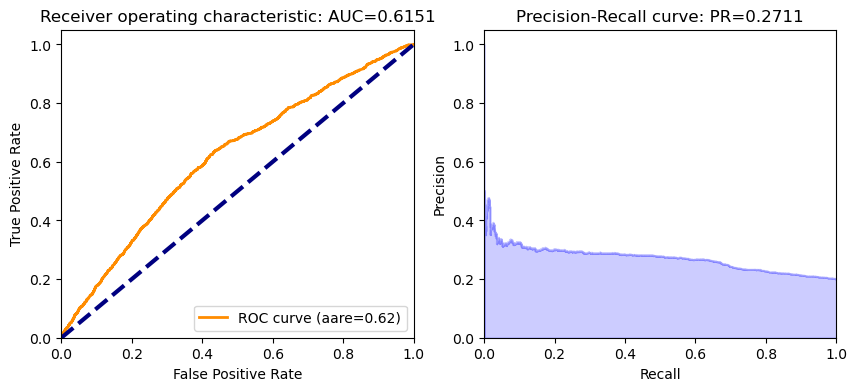

In [68]:
ROC_AUC(aml_v1,test_hex,'loan_default')

### Model 2 - hyperparameters tuning

In [69]:
aml_v2 = H2OAutoML(max_runtime_secs=1000, max_models=30,
                   nfolds=50,
                   seed=1234,
                   balance_classes=True,
                   keep_cross_validation_predictions=True, 
                   keep_cross_validation_models=True,
                   stopping_rounds=3,
                   max_after_balance_size=5.0,
                   include_algos = ["GLM", "DeepLearning", "DRF"])

aml_v2.train(predictors,target,training_frame=train_hex)

AutoML progress: |
19:56:22.958: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.


19:56:24.58: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██████
19:56:28.913: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██████
19:56:36.294: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.


19:56:36.422: DeepLearning_1_AutoM

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_2_20230404_195622


GLM Model: summary
    family    link      regularization             lambda_search                                                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------  ---------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------------------------------------------------------------------------------
    gaussian  identity  Ridge ( lambda = 0.5457 )  nlambda = 30, lambda.max = 5.9081, lambda.min = 0.5457, lambda.1se = 5.9081  15                            15                             6                       AutoML_2_20230404_195622_training_Key_Frame__upload_bdbc8810116f960a8ad1e183063742b4.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.15573655334586006
RMSE: 0.39463470874450474
MAE: 0.31561358004075474
RMSLE: 0.27649511463037985
Mean Residual Deviance: 0.15573655334586006
R^2: 0.05713318253208799
Null degrees of freedom: 799
Residual degrees of freedom: 784
Null deviance: 132.1387499999983
Residual deviance: 124.58924267668806
AIC: 816.630085207729

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.1594514100907845
RMSE: 0.39931367380892996
MAE: 0.31933953172172286
RMSLE: 0.2802373864714037
Mean Residual Deviance: 0.1594514100907845
R^2: 0.03464253996176281
Null degrees of freedom: 799
Residual degrees of freedom: 784
Null deviance: 132.42536963765104
Residual deviance: 127.5611280726276
AIC: 835.4888194487937

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid    cv_11_valid    cv_12_valid    cv_13_valid    cv_14_valid    cv_15_valid    cv_16_valid    cv_17_valid    cv_18_valid    cv_19_valid    cv_20_valid    cv_21_valid    cv_22_valid    cv_23_valid    cv_24_valid    cv_25_valid    cv_26_valid    cv_27_valid    cv_28_valid    cv_29_valid    cv_30_valid    cv_31_valid    cv_32_valid    cv_33_valid    cv_34_valid    cv_35_valid    cv_36_valid    cv_37_valid    cv_38_valid    cv_39_valid    cv_40_valid    cv_41_valid    cv_42_valid    cv_43_valid    cv_44_valid    cv_45_valid    cv_46_valid    cv_47_valid    cv_48_valid    cv_49_valid    cv_50_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
mae                     0.312849  0.0582619  0.291902      0.358285      0.279712      0.254914      0.274804      0.282529      0.38609       0.219447      0.397184      0.308229       0.394386       0.362381       0.300599       0.285448       0.279178       0.331802       0.320592       0.310811       0.279574       0.238463       0.289104       0.352238       0.219178       0.269444       0.282986       0.248571       0.245609       0.318683       0.252615       0.383396       0.346885       0.385543       0.415339       0.371424       0.226973       0.376532       0.335217       0.355192       0.478356       0.3

In [70]:
# View the AutoML Leaderboard
aml_v2.leaderboard

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GLM_1_AutoML_2_20230404_195622,0.399314,0.159451,0.31934,0.280237,0.159451
XRT_1_AutoML_2_20230404_195622,0.412353,0.170035,0.326063,0.294366,0.170035
DRF_1_AutoML_2_20230404_195622,0.413924,0.171333,0.3265,0.295065,0.171333


In [71]:
# Predict Using Leader Model
pred = aml_v2.predict(test_hex)
pred.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0.263901
0.196181
0.254324
0.244308
0.195727
0.319364
0.335661
0.122343
0.273911
0.353381


In [72]:
# let's generate an H2O model performance object here. 
perf = aml_v2.leader.model_performance(test_hex)
perf

ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 0.1540055461596828
RMSE: 0.3924354038051139
MAE: 0.3123852027296974
RMSLE: 0.2766794208062312
Mean Residual Deviance: 0.1540055461596828
R^2: 0.030883866754977674
Null degrees of freedom: 7199
Residual degrees of freedom: 7184
Null deviance: 1144.9787499999352
Residual deviance: 1108.839932349716
AIC: 6997.194903157089

In [73]:
createGains(aml_v2)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,720,242,478,720,242,478,0.17,0.08,142.7,1.70,9.0,33.61
1,720,197,523,1440,439,1001,0.31,0.17,285.4,1.54,14.0,30.49
2,720,176,544,2160,615,1545,0.43,0.27,428.1,1.44,16.0,28.47
3,720,153,567,2880,768,2112,0.54,0.37,570.8,1.35,17.0,26.67
4,720,155,565,3600,923,2677,0.65,0.46,713.5,1.29,19.0,25.64
5,720,140,580,4320,1063,3257,0.74,0.56,856.2,1.24,18.0,24.61
6,720,115,605,5040,1178,3862,0.83,0.67,998.9,1.18,16.0,23.37
7,720,96,624,5760,1274,4486,0.89,0.78,1141.6,1.12,11.0,22.12
8,720,81,639,6480,1355,5125,0.95,0.89,1284.3,1.06,6.0,20.91


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



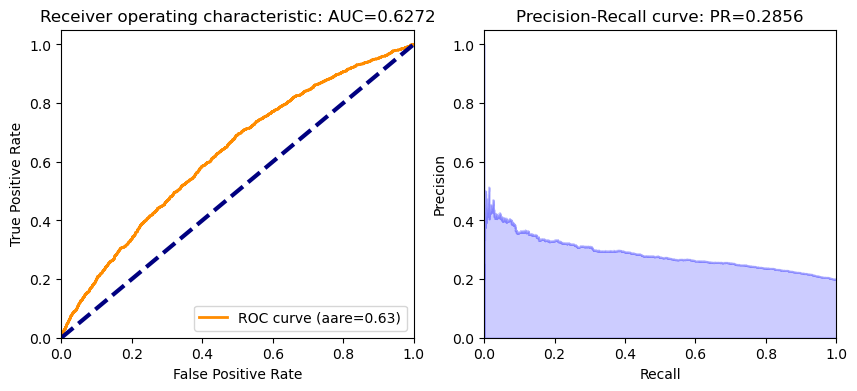

In [74]:
ROC_AUC(aml_v2,test_hex,'loan_default')

# Section 6: Conclusion 

The objective of this data analysis is to create supervised machine learning models capable of identifying high-risk loans or potential defaults, using 15 features with "loan_default" as the target variable. Feature engineering techniques, such as binning and WOE transformation, were employed to enhance model accuracy and performance. Two supervised ML models, a GLM model and AutoML model, were developed using simple hyperparameter and hyperparameter tuning from H2O GridSearch, respectively.

### ROC and Cumulative Lift 

GLM model 
* Model 1 : AUC = 0.6237, PR = 0.2816, lift = 1.31
* Model 2 : AUC = 0.6272, PR = 0.2856, lift = 1.32
* Model 3 : AUC = 0.6289, PR = 0.2873, lift = 1.36

AutoML model
* Model 1 : AUC = 0.6151, PR = 0.2711, lift = 1.49
* Model 2 : AUC = 0.6272, PR = 0.2856, lift = 1.70

In summary, based on the ROC and Cumulative lift, the GLM model with hyper-parameters tuning from H20GridSearch performed the best in identifying high-risk loans or potential defaults.